### Setup

In [1]:
#Import
import GetPbP
import PbPMethods2 as pm2
import pandas as pd
from pylab import *
%matplotlib inline
import seaborn

In [2]:
#Read in Corsi data; write to file once
WRITENEW = False
if WRITENEW:
    w = open('./team corsi data.csv', 'w')
    w.write('Team,Season,CF,CA,CF%,GF,GA,GF%')
    for season in range(2007, 2017):
        for team in pm2.get_teams(season):
            cf = 0
            ca = 0
            gf = 0
            ga = 0
            for line in pm2.read_team_corsi(team, season):
                if pm2.get_acting_team(line) == team:
                    cf += 1
                    if pm2.get_event_type(line) == 'GOAL':
                        gf += 1
                else:
                    ca += 1
                    if pm2.get_event_type(line) == 'GOAL':
                        ga += 1
            w.write('\n{0:s},{1:d},{2:d},{3:d},{4:.1f},{5:d},{6:d},{7:.1f}'.format(
                    team, season, cf, ca, cf/(cf+ca)*100, gf, ga, gf/(gf+ga)*100))
        print('Done with', season)
    w.close()

#Read in data
df = pd.read_csv('./team corsi data.csv') #I provided this file for you in this Github folder as well

### Introduction

The Blue Jackets have made a remarkable turnaround this year, both in the standings (as of Saturday morning, they've won 12 straight games and are first in the league with games in hand) and in the underlying numbers.
<p>Put visually:

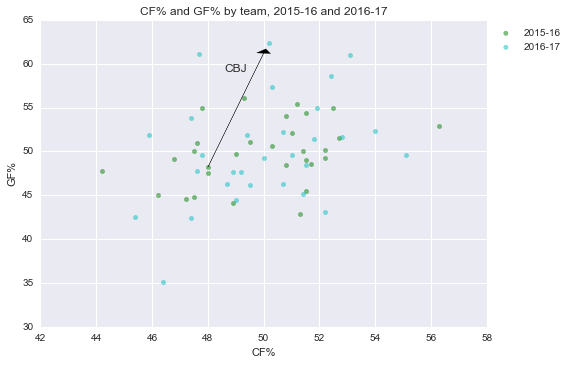

In [3]:
#Scatter: 2015-16 GF% vs CF%
temp = df[df.Season == 2015]
scatter(temp['CF%'], temp['GF%'], color = 'g', alpha = 0.5, label = '2015-16')
temp = df[df.Season == 2016]
scatter(temp['CF%'], temp['GF%'], color = 'c', alpha = 0.5, label = '2016-17')
xlabel('CF%')
ylabel('GF%')
legend(loc=2, bbox_to_anchor=(1, 1), scatterpoints=1)
title('CF% and GF% by team, 2015-16 and 2016-17')

#Label Columbus
arrow(48, 48.2, 2, 13, head_width=0.5, head_length=0.5, fc='k', ec='k')
annotate('CBJ', xy=(49, 60), ha='center', va='top')

That's a pretty nice increase in CF% and an incredible increase in GF%. Both are more impressive after taking into account score effects ([they are 11th in CF% if you adjust for score](http://www.corsica.hockey/teams/)), and may be surprising considering [their coach](http://www.tsn.ca/the-john-tortorella-effect-1.416382). 
<p>How good is Columbus, truly? The elementary school statistics approach might look something like this:
<ul>
<li>Get Columbus' stats so far this year:

In [4]:
df[df.Team == 'CBJ']

,Team,Season,CF,CA,CF%,GF,GA,GF%
8,CBJ,2007,2929,2671,52.3,111,125,47.0
38,CBJ,2008,3265,3043,51.8,157,141,52.7
68,CBJ,2009,2963,3249,47.7,134,165,44.8
98,CBJ,2010,3403,3287,50.9,139,159,46.6
128,CBJ,2011,3123,3439,47.6,129,162,44.3
158,CBJ,2012,1810,2032,47.1,83,80,50.9
188,CBJ,2013,3472,3542,49.5,152,143,51.5
219,CBJ,2014,3233,3597,47.3,144,167,46.3
249,CBJ,2015,3429,3714,48.0,148,159,48.2
279,CBJ,2016,1433,1420,50.2,68,41,62.4


<ul><li>Get the standard deviation of team CF% and GF%

In [5]:
df[['CF%', 'GF%']].std(axis=0)

CF%    2.869213
GF%    4.345730
dtype: float64

<ul><li>Slap those onto either end of Columbus' stats: CF% of 50.2% +/- 2.9, and a GF% of 62.4% +/- 4.3.
</ul>
<p>Maybe the CF% estimate seems reasonable, but the GF% estimate is obviously insane. Only four teams have posted a 5v5 GF% north of 60% in a season prior to this one: 

In [6]:
df[df['GF%'] >= 60]

,Team,Season,CF,CA,CF%,GF,GA,GF%
88,WSH,2009,4299,3742,53.5,225,146,60.6
99,BOS,2010,5069,4947,50.6,235,156,60.1
152,CHI,2012,3280,2724,54.6,156,103,60.2
189,BOS,2013,4339,3734,53.7,189,125,60.2
276,MIN,2016,1396,1529,47.7,69,44,61.1
279,CBJ,2016,1433,1420,50.2,68,41,62.4
292,MTL,2016,1629,1437,53.1,72,46,61.0


To get a better estimate, it might be helpful to take <i>prior expectations</i> into account. This is called Bayesian estimation. Compared to our elementary school approach, you need to form a "prior belief" before starting. Once you have that prior, you can "multiply" by the data you've observed to get an updated <i>posterior</i>.
<p>In our example here, with our prior belief that Columbus was average or below-average coming into the year--I don't think anyone was more optimistic than that--we'd guess that Columbus is somewhere between a bad-to-average team on an incredible run or a good one on great run.
<p>But let's apply numbers to make it more concrete. I'll be drawing from this walkthrough on [empirical Bayes estimation in baseball](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/). (Garik also did [something similar](https://hockey-graphs.com/2014/10/18/bayes-adjusted-fenwick-close-numbers-an-introduction/) a couple of years ago.)

### Estimating a prior

Our first order of business is to select a "prior belief" for how good Columbus should be. We could, for example, look at expert opinions and form a distribution based on that. I'll go simpler than that--the distribution of team CF%. 
(A great prior can be hard to formulate, but even basic ones are often helpful.) 
<p>So let's look at the distribution of team CF% and fit a distribution to it. The distribution I'll fit is the beta distribution, for reasons I'll make clear later.

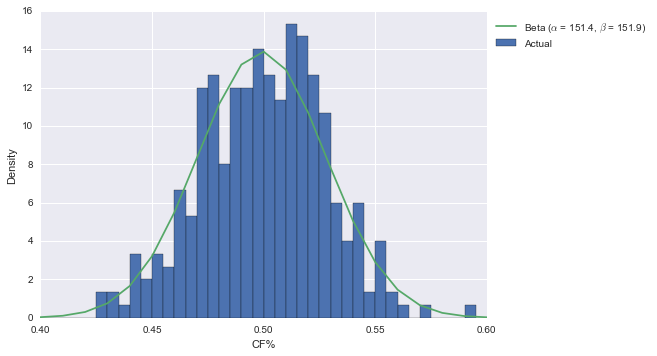

In [7]:
x = df['CF%']/100
xs = arange(0, 1, .01)

hist(x, label='Actual', normed=True, bins=arange(0, 1, 0.005))

from scipy.stats import norm, beta

#u, s = norm.fit(x, loc = .5, scale = 1)
#plot(xs, norm.pdf(xs, u, s), label=r"Normal ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u, s))

a, b, loc, scale = beta.fit(x, floc=0, fscale=1)
plot(xs, beta.pdf(xs, a, b, loc, scale), label=r"Beta ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a, b))

xlim(0.4, 0.6)
xlabel('CF%')
ylabel('Density')
legend(loc=2, bbox_to_anchor=(1, 1))

The CF% distribution is not exactly beta (or normal, for that matter--if you're running the code yourself, comment in the two lines which fit and plot a normal distribution), but it's not <i>that</i> far off--hopefully, it's good enough to be useful here.
<p>SciPy fitted a beta distribution with $\alpha$ ~= $\beta$ ~= 151-152. (Sanity check: the mean should be $\alpha/(\alpha + \beta)$, which, here, is a hair under 50%.) 

### Applying the prior
<p>For complicated priors, we may have to numerically integrate and multiply to get the posterior. But not so for the beta. According to [this post](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) (also linked in the above R-bloggers post), a really convenient aspect of the beta distribution is that the posterior here is merely
<p>$Beta(\alpha_0 + CF, \beta_0 + CA)$
<p>Here's what that looks like, visually:

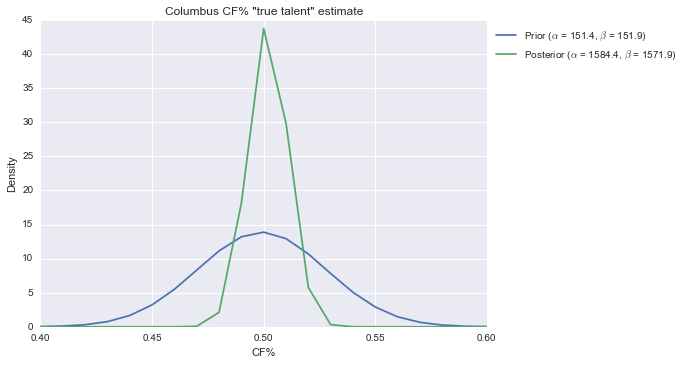

In [8]:
cbjcf = df.iloc[279]['CF'] #See table above--CBJ 2016 is iloc 279
cbjca = df.iloc[279]['CA']

plot(xs, beta.pdf(xs, a, b, loc, scale), 
     label=r"Prior ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a, b))
plot(xs, beta.pdf(xs, a + cbjcf, b + cbjca, loc, scale), 
     label=r"Posterior ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a + cbjcf, b + cbjca))

xlim(0.4, 0.6)
xlabel('CF%')
ylabel('Density')
title('Columbus CF% "true talent" estimate')
legend(loc=2, bbox_to_anchor=(1, 1))

We can see that the center of the posterior distribution hasn't moved significantly compared to the prior--unsurprising, since the prior is centered around 50% and Columbus this season has been roughly a 50% possession team--but the uncertainty has decreased significantly. We're much more confident now that Columbus is roughly average in CF%.
<p>Here's what happens when we apply the same logic to GF%.

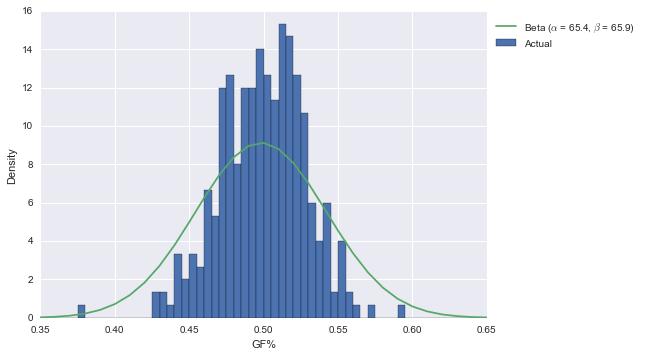

In [9]:
x_gf = df['GF%']/100

hist(x, label='Actual', normed=True, bins=arange(0, 1, 0.005))

#u_gf, s_gf = norm.fit(x, loc = .5, scale = 1)
#plot(xs, norm.pdf(xs, u_gf, s_gf), label=r"Normal ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u_gf, s_gf))

a_gf, b_gf, loc_gf, scale_gf = beta.fit(x_gf, floc=0, fscale=1)
plot(xs, beta.pdf(xs, a_gf, b_gf, loc_gf, scale_gf), 
     label=r"Beta ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf, b_gf))

xlim(0.35, 0.65)
xlabel('GF%')
ylabel('Density')
legend(loc=2, bbox_to_anchor=(1, 1))

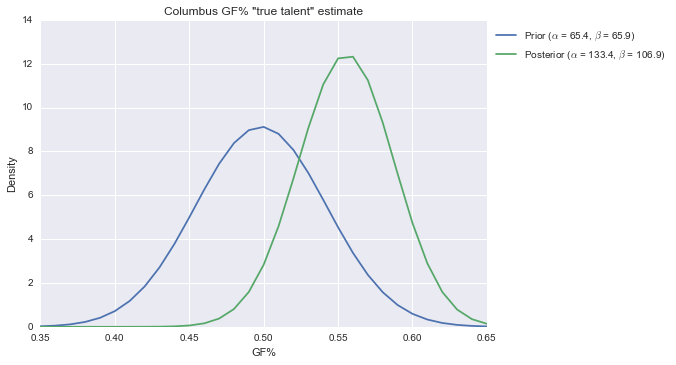

In [10]:
cbjgf = df.iloc[279]['GF'] #See table above--CBJ 2016 is iloc 279
cbjga = df.iloc[279]['GA']

plot(xs, beta.pdf(xs, a_gf, b_gf, loc_gf, scale_gf), 
     label=r"Prior ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf, b_gf))
plot(xs, beta.pdf(xs, a_gf + cbjgf, b_gf + cbjga, loc_gf, scale_gf), 
     label=r"Posterior ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf + cbjgf, b_gf + cbjga))

xlim(0.35, 0.65)
xlabel('GF%')
ylabel('Density')
title('Columbus GF% "true talent" estimate')
legend(loc=2, bbox_to_anchor=(1, 1))

We think Columbus is more like a 55% GF team, with quite a bit of uncertainty on that still. While 55% is closer to average (50%) than the 62%+ the Blue Jackets are sporting at the time of this writing, it's still elite. Take a look at the 55% GF teams below:

In [11]:
df[(df['GF%'] >= 55) & (df.Season < 2016)]

,Team,Season,CF,CA,CF%,GF,GA,GF%
25,DET,2007,4453,3077,59.1,188,126,59.9
39,BOS,2008,3791,3740,50.3,191,129,59.7
55,DET,2008,4780,3589,57.1,217,167,56.5
83,VAN,2009,3958,3658,52.0,203,156,56.5
88,WSH,2009,4299,3742,53.5,225,146,60.6
99,BOS,2010,5069,4947,50.6,235,156,60.1
129,BOS,2011,4329,3677,54.1,201,157,56.1
135,STL,2011,3932,3544,52.6,148,115,56.3
145,DET,2011,3872,3168,55.0,183,133,57.9
151,PIT,2012,2733,2861,48.9,139,109,56.0


We should also caveat that conclusion with the fact that our beta prior was probably spread wider than we'd like; a narrower prior might lead to a more modest "true talent" estimate for Columbus.

### Better prior
<p>We also might want to use a more informative prior belief. After all, our prior above was based on all teams, while Columbus was below average in 2015-16. 
<p>Our prior can get arbitrarily complex; to keep things simple, rather than using all teams, I'll only use teams in a season that, in the previous season, had Columbus' GF% and CF%, plus or minus a couple of percentage points.

In [12]:
#Create a new dataframe with Year and Year+1 data
df_newprior = df
df_newprior['Season+1'] = df_newprior.Season + 1
df_newprior = df_newprior.merge(df_newprior, how='inner', left_on=['Team', 'Season+1'], right_on=['Team','Season'])
df_newprior.rename(columns={'Season_x': 'Season', 'CF_x': 'CF', 'CA_x': 'CA', 'CF%_x': 'CF%',
                           'GF_x': 'GF', 'GA_x': 'GA', 'GF%_x': 'GF%', 'Season+1_x': 'Season+1',
                           'CF_y': 'CF+1', 'CA_y': 'CA+1', 'CF%_y': 'CF%+1',
                           'GF_y': 'GF+1', 'GA_y': 'GA+1', 'GF%_y': 'GF%+1'}, inplace=True)
df_newprior.drop(['Season_y', 'Season+1_y'], axis=1, inplace=True)
df_newprior.head()

,Team,Season,CF,CA,CF%,GF,GA,GF%,Season+1,CF+1,CA+1,CF%+1,GF+1,GA+1,GF%+1
0,N.J,2007,3289,3005,52.3,128,132,49.2,2008,3735,3410,52.3,160,134,54.4
1,PIT,2007,3554,4290,45.3,175,150,53.8,2008,4163,4477,48.2,214,184,53.8
2,CHI,2007,2683,2703,49.8,143,133,51.8,2008,4004,3378,54.2,181,162,52.8
3,EDM,2007,2958,3424,46.3,143,166,46.3,2008,3160,3482,47.6,150,145,50.8
4,CAR,2007,3443,3194,51.9,153,145,51.3,2008,4484,4160,51.9,168,177,48.7


In [13]:
#Filter out Columbus proximates
df_newprior_filtered = df_newprior[df['Season+1'] < 2016]

cbjcfpct = df.iloc[249]['CF%']
cbjgfpct = df.iloc[249]['GF%']

df_newprior_filtered = df_newprior_filtered[(df_newprior_filtered['CF%'] <= cbjcfpct + 2) &
                                           (df_newprior_filtered['CF%'] >= cbjcfpct - 2) &
                                           (df_newprior_filtered['GF%'] <= cbjgfpct + 2) &
                                           (df_newprior_filtered['GF%'] >= cbjgfpct - 2)]
print('Comparables:', len(df_newprior_filtered))
#df_newprior_filtered

Comparables: 42


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


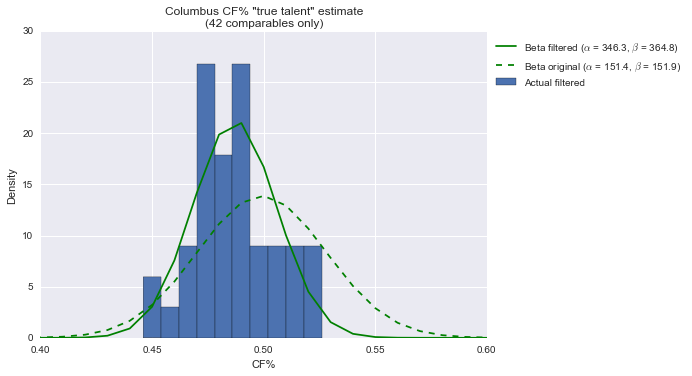

In [14]:
#Follow same process as above
x_filtered = df_newprior_filtered['CF%+1']/100

hist(x_filtered, label='Actual filtered', normed=True)

cbjcf = df.iloc[279]['CF'] #See table above--CBJ 2016 is iloc 279
cbjca = df.iloc[279]['CA']

#u_filtered, s_filtered = norm.fit(x_filtered, loc = .5, scale = 1)
#plot(xs, norm.pdf(xs, u_filtered, s_filtered), 
#     label=r"Normal filtered ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u_filtered, s_filtered))

a_filtered, b_filtered, loc_filtered, scale_filtered = beta.fit(x_filtered, floc=0, fscale=1)
plot(xs, beta.pdf(xs, a_filtered, b_filtered, loc_filtered, scale_filtered), color='g', ls = '-',
     label=r"Beta filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_filtered, b_filtered))

#plot(xs, norm.pdf(xs, u, s), 
#     label=r"Normal original ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u, s))
plot(xs, beta.pdf(xs, a, b, loc, scale), color = 'g', ls = '--',
     label=r"Beta original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a, b))

xlim(0.4, 0.6)
xlabel('CF%')
ylabel('Density')
title('Columbus CF% "true talent" estimate\n({0:d} comparables only)'.format(len(df_newprior_filtered)))
legend(loc=2, bbox_to_anchor=(1, 1))

No surprise--the prior consisting of "comparable" teams is shifted to the left and narrower compared to the prior that consisted of all teams.

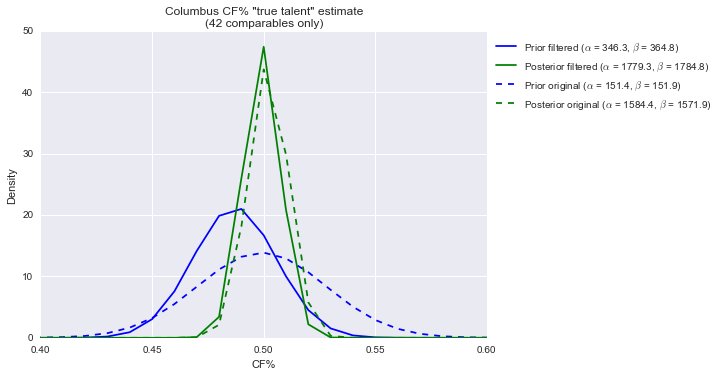

In [15]:
cbjcf = df.iloc[279]['CF'] #See table above--CBJ 2016 is iloc 279
cbjca = df.iloc[279]['CA']

plot(xs, beta.pdf(xs, a_filtered, b_filtered, loc_filtered, scale_filtered), color='b', ls = '-',
     label=r"Prior filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_filtered, b_filtered))
plot(xs, beta.pdf(xs, a_filtered + cbjcf, b_filtered + cbjca, loc_filtered, scale_filtered), color='g', ls = '-',
     label=r"Posterior filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_filtered + cbjcf, b_filtered + cbjca))

plot(xs, beta.pdf(xs, a, b, loc, scale), color='b', ls = '--',
     label=r"Prior original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a, b))
plot(xs, beta.pdf(xs, a + cbjcf, b + cbjca, loc, scale), color='g', ls = '--',
     label=r"Posterior original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a + cbjcf, b + cbjca))

xlim(0.4, 0.6)
xlabel('CF%')
ylabel('Density')
title('Columbus CF% "true talent" estimate\n({0:d} comparables only)'.format(len(df_newprior_filtered)))
legend(loc=2, bbox_to_anchor=(1, 1))

Pretty much the same as above. 
<p>Now for GF%:

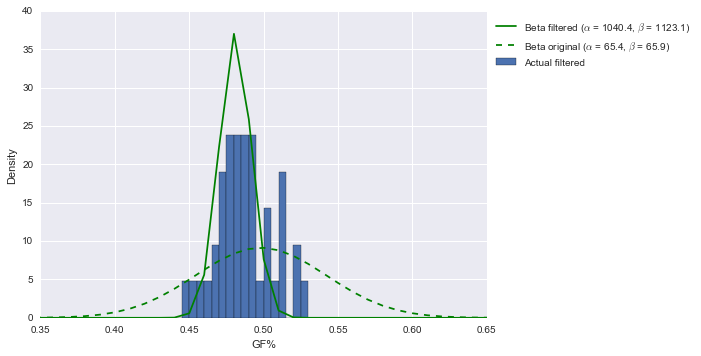

In [16]:
x_gf_filtered = df_newprior_filtered['GF%']/100

hist(x_filtered, label='Actual filtered', normed=True, bins=arange(0, 1, 0.005))

#u_gf_filtered, s_gf_filtered = norm.fit(x_filtered, loc = .5, scale = 1)
#plot(xs, norm.pdf(xs, u_gf_filtered, s_gf_filtered), 
#     label=r"Normal filtered ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u_gf_filtered, s_gf_filtered))

a_gf_filtered, b_gf_filtered, loc_gf_filtered, scale_gf_filtered = beta.fit(x_gf_filtered, floc=0, fscale=1)
plot(xs, beta.pdf(xs, a_gf_filtered, b_gf_filtered, loc_gf_filtered, scale_gf_filtered), color='g', ls = '-',
     label=r"Beta filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf_filtered, b_gf_filtered))

#plot(xs, norm.pdf(xs, u_gf, s_gf), 
#     label=r"Normal original ($\mu$ = {0:.1f}, $\sigma$ = {1:.1f})".format(u_gf, s_gf))
plot(xs, beta.pdf(xs, a_gf, b_gf, loc_gf, scale_gf), color='g', ls='--',
     label=r"Beta original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf, b_gf))

xlim(0.35, 0.65)
xlabel('GF%')
ylabel('Density')
legend(loc=2, bbox_to_anchor=(1, 1))

Compared to the original, the filtered prior is far narrower and shifted slightly to the left.

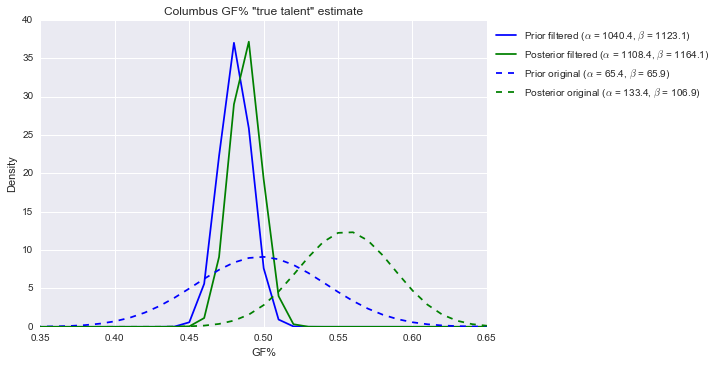

In [17]:
cbjgf = df.iloc[279]['GF'] #See table above--CBJ 2016 is iloc 279
cbjga = df.iloc[279]['GA']

plot(xs, beta.pdf(xs, a_gf_filtered, b_gf_filtered, loc_gf_filtered, scale_gf_filtered), color='b', ls='-',
     label=r"Prior filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf_filtered, b_gf_filtered))
plot(xs, beta.pdf(xs, a_gf_filtered + cbjgf, b_gf_filtered + cbjga, loc_gf_filtered, scale_gf_filtered), color='g', ls='-',
     label=r"Posterior filtered ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf_filtered + cbjgf, b_gf_filtered + cbjga))

plot(xs, beta.pdf(xs, a_gf, b_gf, loc_gf, scale_gf), color='b', ls='--',
     label=r"Prior original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf, b_gf))
plot(xs, beta.pdf(xs, a_gf + cbjgf, b_gf + cbjga, loc_gf, scale_gf), color='g', ls='--',
     label=r"Posterior original ($\alpha$ = {0:.1f}, $\beta$ = {1:.1f})".format(a_gf + cbjgf, b_gf + cbjga))

xlim(0.35, 0.65)
xlabel('GF%')
ylabel('Density')
title('Columbus GF% "true talent" estimate')
legend(loc=2, bbox_to_anchor=(1, 1))

Now this is interesting. Our "filtered posterior" is <i>far</i> different from the original posterior! The center of this posterior is:

In [18]:
print('Center = {0:.1f}%'.format(100 * (a_gf_filtered + cbjgf)/
                                 (a_gf_filtered + cbjgf + b_gf_filtered + cbjga)))

Center = 48.8%


Our posterior still puts Columbus' "true talent" below 50% in GF%, centered around 49% with about 80% of the distribution below 50%. In other words, despite 32 games of outstanding goal differential, Columbus hasn't even even pulled our posterior from "below-average" to "average."
<p>Now, again, it is worth noting that our prior does not perfectly fit the distribution. In particular, it looks like there should be more uncertainty. That would imply more movement in the posterior, perhaps even to average, and probably some more uncertainty. But it's hard to imagine us getting back all the way to "elite."

### Conclusion
<p>Incorporating our prior beliefs should, in theory, improve our predictions and analysis of what happens early on a season. Here, I do not demonstrate that Bayesian thinking helps, but rather what the results of an empirical Bayes estimation would be of one of this year's biggest surprises, Columbus. With a prior derived from the set of all teams from 2007-15, Columbus' average possession numbers and otherwordly goal ratio appear to be more like average possession and elite GF%; with a prior derived from the set of teams that had similar CF% and GF% to Columbus last year, the Blue Jackets look like an average possession team with a below-average GF%.
<p>That's a huge difference. Personally, given the coaching and my take on the talent on that team, I think the latter is a tad closer to "the truth" than the former. In other words, I think Columbus is around average in possession and may be slightly better in GF%. Slightly.
<p>But it's also worth remembering that coming into last season, a lot of people were pretty high on Columbus. I also think it's possible that they more talent than most people give them credit for, and combined with a coach who may have adapted to a new game, some developing young talent (like Alexander Wennberg, Zach Werenski, and Seth Jones), some undervalued offseason acquisitions (like Sam Gagner), and a very good goalie, they're legitimately a good, solid team.